In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.wrappers import RecordVideo
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [14]:
#Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Agent
class Agent:
    def __init__(self):
        self.q_network = DQN(input_size, output_size).to(device)
        self.target_network = DQN(input_size, output_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = Memory(memory_size)

    def q_updation(self, gamma, size):
        if len(self.replay_buffer) < size:
            return
        
        batch = self.replay_buffer.get(size)
        states, actions, rewards, next_states, dones = batch

        states = torch.as_tensor(states, dtype=torch.float32, device=device)
        next_states = torch.as_tensor(next_states, dtype=torch.float32, device=device)
        actions = torch.as_tensor(actions, dtype=torch.int64, device=device).unsqueeze(-1)
        rewards = torch.as_tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.as_tensor(dones, dtype=torch.bool, device=device)

        current_q_values = self.q_network(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            expected_q_values = rewards + gamma * next_q_values * (~dones)

        loss = nn.functional.mse_loss(current_q_values.squeeze(-1), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state, epsilon):
        if random.random() > epsilon:
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
                action = torch.argmax(q_values, dim=1).item()
        else:
            action = random.randint(0, output_size - 1)

        return action



class Memory:
    def __init__(self, size):
        self.memory = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get(self, batch):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.memory)


In [15]:
gamma = 0.99
batch_size = 64
lr = 0.0003
t_interval_update = 6
memory_size = 150000
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 150000


env = gym.make('LunarLander-v2')
env.seed(RANDOM_SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n



num_episodes = 2000

rolling_window = 100
episode_rewards = []
avg_rewards = []

def train():
    agent = Agent()
    episode_rewards = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.q_updation(gamma, batch_size)

            epsilon = max(epsilon_final, epsilon - (epsilon_start - epsilon_final) / epsilon_decay)  # Epsilon decay

        episode_rewards.append(total_reward)

        if episode % t_interval_update == 0:
            agent.target_network.load_state_dict(agent.q_network.state_dict())

        if episode >= rolling_window:
            avg_reward = np.mean(episode_rewards[episode-rolling_window:episode])
            avg_rewards.append(avg_reward)
        else:
            avg_reward = np.mean(episode_rewards[:episode+1])
            avg_rewards.append(avg_reward)
        
        current_lr = agent.optimizer.param_groups[0]['lr']
        print('Episode: {}, Total reward: {}, Average Rewards: {}, Epsilon: {:.2f}, Learning_rate: {}'.format(episode, total_reward, avg_reward, epsilon, current_lr))

    return episode_rewards, avg_rewards

    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
    return episode_rewards, avg_rewards

    
episode_rewards, avg_rewards = train()
env.close()

C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


Episode: 0, Total reward: -122.94725570383171, Average Rewards: -122.94725570383171, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 1, Total reward: -113.2494200549402, Average Rewards: -118.09833787938595, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 2, Total reward: -75.4740819622, Average Rewards: -103.89025257365729, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 3, Total reward: -246.1905414749282, Average Rewards: -139.46532479897502, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 4, Total reward: -151.08920641817423, Average Rewards: -141.79010112281486, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 5, Total reward: -280.3612818370011, Average Rewards: -164.88529790851257, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 6, Total reward: -347.1504506505289, Average Rewards: -190.92317687165774, Epsilon: 1.00, Learning_rate: 0.0003
Episode: 7, Total reward: -88.49802227671016, Average Rewards: -178.12003254728933, Epsilon: 0.99, Learning_rate: 0.0003
Episode: 8, Total reward: -125.968

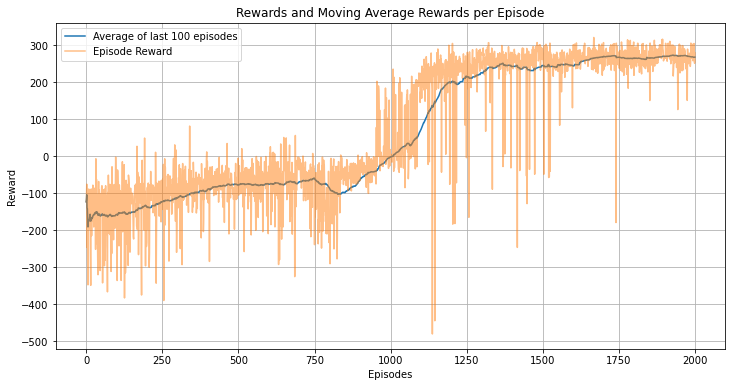

In [20]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(avg_rewards, label='Average of last 100 episodes')
ax.plot(episode_rewards, alpha=0.5, label='Episode Reward')

ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('Rewards and Moving Average Rewards per Episode')
ax.legend()
ax.grid(True)

plt.show()

# print('avg_rewards', avg_rewards)
# print('episode_rewards', episode_rewards)

In [21]:
def save_agent(agent, filepath):
    
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    torch.save({
        'q_network_state_dict': agent.q_network.state_dict(),
        'target_network_state_dict': agent.target_network.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict()
    }, filepath)


def load_agent(agent, filepath):
    checkpoint = torch.load(filepath)

    agent.q_network.load_state_dict(checkpoint['q_network_state_dict'])
    agent.target_network.load_state_dict(checkpoint['target_network_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
save_agent(agent, 'Saved_files/DQN/dqn_agent.pth')

In [ ]:
episode_rewards = np.array(episode_rewards)
episode_rewards.dump(open('Saved_files/DQN/DQN_episode_rewards.npy', 'wb'))

avg_rewards = np.array(avg_rewards)
avg_rewards.dump(open('Saved_files/DQN/DQN_avg_rewards.npy', 'wb'))



In [ ]:
#To render the environment with agents
import time
def play_episodes(agent, env_name='LunarLander-v2', num_episodes=10, render=True, save_dir):
    env = gym.make(env_name)
    env = RecordVideo(env, save_dir)
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            if render:
                env.render()
                time.sleep(0.01)  # Slow down the rendering for better visualization

            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = agent.q_network(state_tensor).max(1)[1].item()
            
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)
        print(f'Episode {episode + 1}: Total Reward: {episode_reward}')

    env.close()
    avg_reward = np.mean(total_rewards)
    print(f'Average Reward over {num_episodes} episodes: {avg_reward}')

#### Play Random Agent

In [ ]:
random_agent = Agent()
play_episodes(random_agent, './Saved_files/DQN')

#### Play DQN Trained Agent

In [ ]:
trained_agent = load_agent(agent, './Saved_files/DQN/dqn_agent.pth')
play_episodes(trained_agent, './Saved_files/DQN')